# Import the csvs and make plots

In [2]:
#!/usr/bin/python
# by DBR 6/2016 #

%matplotlib inline  

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats.mstats import gmean
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import xlrd
from itertools import takewhile

#import warnings
#warnings.filterwarnings('ignore')

plt.style.use('ggplot')

cz=[ 'darkcyan','indigo','blue', 'royalblue','indianred', 'darkred', 'salmon', 'red']


/Users/danielreeves/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
#method from stackoverflow that can pull the length of a specific column
def column_len(sheet, index):
    col_values = sheet.col_values(index)
    col_len = len(col_values)
    for _ in takewhile(lambda x: not x, reversed(col_values)):
        col_len -= 1
    return col_len

book = xlrd.open_workbook("dbr_vldata.xlsx") #open book
sh = book.sheet_by_index(1) #get sheet name

#list the cohorts as they show up in excel
Contr = ['Z09087','Z09106','Z09192','A11201','Z09204'] #control
Trans = ['Z09144','Z08214','Z09125','A11200','Z09196'] #transplant
Nctlr = ['A11214']                                     #natural controller
Stabl = ['A11213','A11221']                            #stable set point no cART
CCR5T = ['A11219','R10155','T10187','R10159','T10173',
          'Z12037','Z12216','Z11151','Z12351','Z12370',
          'Z13133','Z12417','Z12420']                   #ccr5delta mutation transplant

cohorts     = [Contr,Trans,Nctlr,Stabl,CCR5T]
cohort_names= ['Control','Transplant','Natural Controller','Stable ART',r'CCR5$\Delta$ Transplant']
list_names  = [Contr+Trans+Nctlr+Stabl+CCR5T]
list_names  = list_names[0]
num_monkeys = len(list_names)

ATI_list = ['Z09087','Z09106','Z09192','Z09204','Z09144','Z08214','A11200','Z09196'] #8 good rebounds

In [4]:
#loop through all monkeys to get all possible time points organized
tT=[]
for m in range(num_monkeys):    
    numT = column_len(sh,2*m) #number of time points for each monkey
    [tT.append(float(sh.cell_value(rx,2*m))) for rx in range(1,numT)] #put together time data    
tT=sorted(set(tT)) #remove duplicates and sort, get all unique time points in order

In [5]:
#get a list of the names as they appear in the excel file 
#(not in order by cohort or anything so have to do this extra)
names_in_order=[]
for m in range(1,num_monkeys*2+1,2):
    names_in_order.append(str(sh.cell_value(0,m)))
    
#names_in_order

In [6]:
#loop through all time points, append nans to vL if missing
d={'weeks':tT} #make a dictionary we can add to
mxindex=0
for m in range(num_monkeys):    
    vLoad=[]; inT=1
    for tx in range(len(tT)):        
        if float(sh.cell_value(inT,mxindex)) != tT[tx]:
            vLoad.append(None)
        else:
            vLoad.append(sh.cell_value(inT,mxindex+1))
            inT+=1
    mxindex+=2  
    d[names_in_order[m]]=vLoad #add to the dictionary with the name            
df = pd.DataFrame(data=d) #make the dataframe with the viral load data!

In [7]:
#do the primary infection a bit more simply, just to the first instance of ART

onART = [26,26,24,24,24,24,25,25,25,25,25,25,0,0,25,25,25,25,25,25,25,25,25,25,25,25] #list of ART weeks from excel

idx_ART = df[df['weeks'] == 21].index.tolist()[0] #the index of the earliest ART start
idx_PI  = df[df['weeks'] == 0].index.tolist()[0]  #the index of the primary infection


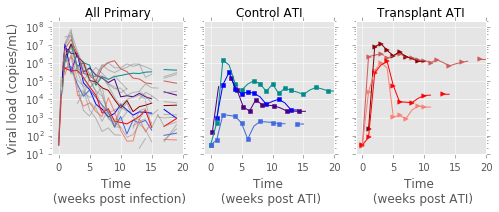

In [31]:
#concatenate the 3 cohorts of interest, ignoring stable and natural controllers
prim_df=pd.concat([df[cohorts[0]][idx_PI:idx_ART], 
                   df[cohorts[1]][idx_PI:idx_ART], 
                   df[cohorts[4]][idx_PI:idx_ART]], axis=1)

prim_weeks = df['weeks'][idx_PI:idx_ART] #get the weeks of primary infection

fig,axarr = plt.subplots(1,3,sharey=True,figsize=(7,3),dpi=600)

#axarr[0].semilogy(prim_weeks,10**np.nanmean(np.log10(df[cohorts[0]][idx_PI:idx_ART]),1),color='blue',lw=2) #plot control mean
#axarr[0].semilogy(prim_weeks,10**np.nanmean(np.log10(df[cohorts[1]][idx_PI:idx_ART]),1),color='red',lw=2) #plot transplant geomean
#axarr[0].semilogy(prim_weeks,10**np.nanmean(np.log10(df[cohorts[4]][idx_PI:idx_ART]),1),color='black',lw=2) #plot ccr5 transplant geomean
#axarr[0].semilogy(prim_weeks,10**np.nanmean(np.log10(prim_df),1),color='black',lw=3) #plot total geomean

nz=['All Primary','Control ATI','Transplant ATI']
for i in range(3):
    axarr[i].set_title(nz[i],fontsize=12)
    axarr[i].set_ylim([10,2e8])
    axarr[i].set_xlim([-1,20])
axarr[0].set_ylabel('Viral load (copies/mL)')
axarr[0].set_xlabel('Time \n (weeks post infection)')
axarr[1].set_xlabel('Time \n (weeks post ATI)')
axarr[2].set_xlabel('Time \n (weeks post ATI)')

#find the analytic treatment interruption viral loads
offART = [77,77,81,81,81,0,84,81,81,81,90,0,0,0,0,89,0,0,0,0,0,0,0,0,0,0]
ATI_df=pd.DataFrame(columns=ATI_list) #dataframe for ATI viral loads
ATI_weeks_df=pd.DataFrame(columns=ATI_list) #dataframe for ATI times

ATI_weeks={}

for i in range(len(names_in_order)):
    
    if names_in_order[i] in ATI_list:
    
        idx_ATI = df[df['weeks'] == offART[i]].index.tolist()[0] #find the index of ATI

        idx_Reb = idx_ATI #assume rebound at ATI
        
        #then adjust so reb at first positive 
        #print names_in_order[i]
        rebound=False
        #adjust index to be first positive index
        while rebound==False:
            if np.isnan(df[names_in_order[i]][idx_Reb]) or df[names_in_order[i]][idx_Reb]<=30:
                rebound=False
                idx_Reb+=1
            else:
                rebound=True
                idx_Reb-=1 #now start at index just before the first positive
            #print df[names_in_order[i]][idx_Reb] #print to check it is working
        
        #now fill up ATI dataframes
        ATI_df[names_in_order[i]]=df[names_in_order[i]][idx_Reb:]
        ATI_weeks_df[names_in_order[i]]=df['weeks'][idx_Reb:]
        ATI_weeks[names_in_order[i]]=df['weeks'][idx_Reb]#offART[i]

cind=0; tind=0
for m in list_names:
    
    if m in CCR5T:
        axarr[0].semilogy(prim_weeks,prim_df[m],color='gray',alpha=0.5)
    if m in Contr and m in ATI_list:
        axarr[0].semilogy(prim_weeks,prim_df[m],color=cz[cind])#,alpha=0.5)
        cind+=1
    if m in Trans and m in ATI_list:
        axarr[0].semilogy(prim_weeks,prim_df[m],color=cz[tind+4])#,alpha=0.5)
        tind+=1

ATI_sp=[]
cind=0; tind=0
for i in range(len(ATI_list)):
    
    data_raw=ATI_df[ATI_list[i]] #not interpolated
    ATI_sp.append(10**np.nanmean(np.log10(data_raw[tpts>6]))) #calculating the geometric mean of setpoint post 6 weeks rebound
    #data_interp=ATI_df[ATI_list[i]].interpolate(method='linear',axis=0,limit=1) #interpolated 1
    data_interp=ATI_df[ATI_list[i]].interpolate(method='linear',axis=0,limit=1) #interpolated 2
    tpts=ATI_weeks_df[ATI_list[i]]-ATI_weeks[ATI_list[i]]
    if ATI_list[i] in Contr:
        #axarr[0].semilogy(prim_weeks[ATI_list[i]],prim_df[ATI_list[i]],color=cz[cind],alpha=0.5)#plot same color in first subplot
        axarr[1].scatter(tpts,data_raw,marker='s',color=cz[cind])
        axarr[1].semilogy(tpts,data_interp,color=cz[cind])
        cind+=1
    elif ATI_list[i] in Trans:
        #axarr[0].semilogy(prim_weeks[ATI_list[i]],prim_df[ATI_list[i]],color=cz[cind],alpha=0.5)#plot same color in first subplot
        axarr[2].scatter(tpts,data_raw,marker='>',color=cz[tind+4])
        axarr[2].semilogy(tpts,data_interp,color=cz[tind+4])
        tind+=1

plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gcf().savefig('fig2_outbreaks.pdf')  # No warning now


In [9]:
#if want to print the csv again
#pd.DataFrame.to_csv(df,path_or_buf='VL.csv')

In [25]:
prim_df

,Z09087,Z09106,Z09192,A11201,Z09204,Z09144,Z08214,Z09125,A11200,Z09196,...,R10159,T10173,Z12037,Z12216,Z11151,Z12351,Z12370,Z13133,Z12417,Z12420
2,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
3,NaN,NaN,NaN,1409.0,29449.0,NaN,NaN,NaN,7442.0,19424.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114549.0,161889.0
4,69956.0,158779.0,161066.0,NaN,NaN,420969.0,52246.0,177698.0,NaN,NaN,...,36062.0,938868.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1132222.0,7621594.0,10998928.0,417691.0,546250.0,6026033.0,1915324.0,9849907.0,222914.0,515191.0,...,3678155.0,2822635.0,27811295.0,10661493.0,12401403.0,8968500.0,7509316.0,55360978.0,1131130.0,1265743.0
6,9928549.0,3394484.0,321130.0,1018638.0,637724.0,20387157.0,11473731.0,8446774.0,2801779.0,373680.0,...,4318015.0,461798.0,32260599.0,50396078.0,73213740.0,34634216.0,NaN,NaN,NaN,NaN
7,676436.0,3179064.0,3476654.0,11705.0,69021.0,3309479.0,2350574.0,1103801.0,21863.0,394746.0,...,118854.0,55551.0,500109.0,4655726.0,304475.0,362021.0,2764697.0,5966.0,16876.0,26337.0
8,1051335.0,315320.0,80942.0,2993.0,14783.0,274226.0,1098525.0,96271.0,4211.0,160557.0,...,54618.0,2435.0,368510.0,663376.0,271981.0,43994.0,473792.0,24539.0,17625.0,29889.0
9,764386.0,545291.0,33639.0,5512.0,33292.0,214392.0,110456.0,25673.0,6365.0,49104.0,...,40365.0,1189.0,464105.0,253028.0,164773.0,6984.0,108843.0,13043.0,149525.0,2548.0
10,59599.0,213251.0,5493.0,1019.0,13162.0,100920.0,92349.0,3894.0,2154.0,16988.0,...,131729.0,5077.0,238553.0,564906.0,190447.0,3250.0,29642.0,16659.0,24585.0,899.0
11,182663.0,150746.0,2912.0,1318.0,4836.0,551728.0,43432.0,7117.0,1124.0,1771.0,...,19009.0,2101.0,167748.0,276655.0,196590.0,623.0,15315.0,51065.0,4499.0,172.0


# Descriptive statistics!

In [10]:
#make a dataframe for results
#descripts = pd.DataFrame(columns=[df.columns])
#descripts['stat']=[]

a=df.columns.tolist()#.copy()
a.remove('weeks')
#a.insert(0,'stat')

descripts = pd.DataFrame(columns=a)

#descripts.loc[0,'stat']='first_pos'
#descripts.loc[1,'stat']='first_pos_VL'
#descripts.loc[2,'stat']='max_VL'
#descripts.loc[3,'stat']='setpoint_avg'
#descripts.loc[4,'stat']='setpoint_std'
#descripts.loc[5,'stat']='first_pos_ATI'
#descripts.loc[6,'stat']='first_pos_VL_ATI'
#descripts.loc[7,'stat']='max_ATI_VL'
#descripts.loc[8,'stat']='setpoint_ATI_avg'
#descripts.loc[9,'stat']='setpoint_ATI_std'


In [11]:
descripts_list = ['Monkey','First pos','First pos VL','Max VL','Set-point avg',
                  'Set-point std','ATI First pos', 'ATI First pos VL',
                 'ATI max VL','ATI Set-point avg','ATI Set-point std']


In [12]:
#first positive and magntidue VL at first positive

#primary
for i in range(num_monkeys):
    VL=0; j=0
    while VL<=30 or np.isnan(VL):
        j+=1
        VL=df.iloc[:,i][j]
    descripts.loc[0,df.columns[i]]=df.weeks[j]
    descripts.loc[1,df.columns[i]]=VL

#ATI
for i in range(len(ATI_list)):
    VL=0; j=80
    while VL<=30 or np.isnan(VL):
        j+=1
        VL=ATI_df[ATI_list[i]][j]
    descripts.loc[5,ATI_list[i]]=ATI_weeks_df[ATI_list[i]][j]
    descripts.loc[6,ATI_list[i]]=VL

In [13]:
#peak VL and setpoint VL (determined by VL > 10 weeks)

#primary values
idx1=df[df.weeks==10].index.tolist()[0]; idx2=df[df.weeks==21].index.tolist()[0] #indices for setpoint 10 -> preART
for i in range(num_monkeys): 
    descripts.loc[2,df.columns[i]]=np.nanmax(df[df.columns[i]][0:20])[0] #max in first 20 always
    descripts.loc[3,df.columns[i]]=10**np.nanmean(np.log10(df.loc[idx1:idx2,df.columns[i]])) #gmean setpoint
    descripts.loc[4,df.columns[i]]=10**np.nanstd(np.log10(df.loc[idx1:idx2,df.columns[i]])) #gstd setpoint
    #descripts.loc[3,df.columns[i]]=np.nanmean(df.loc[idx1:idx2,df.columns[i]]) #mean setpoint
    #descripts.loc[4,df.columns[i]]=np.nanstd(df.loc[idx1:idx2,df.columns[i]]) #std setpoint

#ATI values
for i in range(len(ATI_list)):     
    
    descripts.loc[7,ATI_list[i]]=np.nanmax(ATI_df[ATI_list[i]].tolist()) #peak VL
    descripts.loc[8,ATI_list[i]]=ATI_sp[i] #avg calculated above
    
    descripts.loc[9,ATI_list[i]]=np.nan #std


## Comparing peaks and set-points and first positives etc

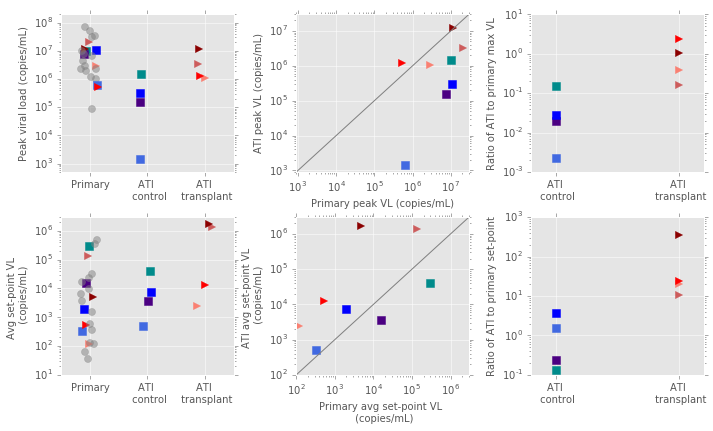

In [14]:
#compare peak viral loads
noise=0.15
plt.figure(figsize=(10,6),dpi=600)

plt.subplot(231)
cind=0; tind=0
for j in range(len(prim_df.keys())):        
    if prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Contr:
        mflag='Control'
        markz='s'
        alz=1
        col=cz[cind]
        cind+=1
    elif prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Trans:
        mflag='Transplant'
        markz='>'
        alz=1
        col=cz[tind+4]
        tind+=1 
    else:
        markz='o'
        col='gray'
        alz=0.5
    
    plt.scatter(1+np.random.uniform(low=-noise, high=noise, size=1),descripts[list_names[j]][2],
           color=col,marker=markz,alpha=alz,s=50)

for i in range(4):
    plt.scatter(2+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[7,ATI_list[i]],
                color=cz[i],s=50,marker='s')

    plt.scatter(3+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[7,ATI_list[i+4]],
                color=cz[i+4],s=50,marker='>')

plt.xticks([1,2,3],['Primary','ATI \n control','ATI \n transplant'])
plt.ylabel('Peak viral load (copies/mL)',fontsize=10)
plt.yscale('log')
plt.ylim([500,2e8])

plt.subplot(232)
for i in range(4):
    plt.scatter(descripts.loc[2,ATI_list[i]],descripts.loc[7,ATI_list[i]],color=cz[i],s=50,marker='s')
    plt.scatter(descripts.loc[2,ATI_list[i+4]],descripts.loc[7,ATI_list[i+4]],color=cz[i+4],s=50,marker='>')
plt.xscale('log')
plt.xlabel('Primary peak VL (copies/mL)',fontsize=10)
plt.ylabel('ATI peak VL (copies/mL)',fontsize=10)
plt.yscale('log')
plt.ylim([900,3e7])
plt.xlim([900,3e7])
plt.semilogy(np.linspace(10,2e8,100),np.linspace(10,2e8,100),'gray')

plt.subplot(233)
for i in range(4):
    plt.scatter(1,descripts.loc[7,ATI_list[i]]/descripts.loc[2,ATI_list[i]],color=cz[i],s=50,marker='s')
    plt.scatter(2,descripts.loc[7,ATI_list[i+4]]/descripts.loc[2,ATI_list[i+4]],color=cz[i+4],s=50,marker='>')
plt.xticks([1,2],['ATI \n control','ATI \n transplant'])
plt.ylabel('Ratio of ATI to primary max VL',fontsize=10)
plt.yscale('log')
#plt.ylim([100,3e6])
#plt.xlim([100,3e6])

#compare avg viral loads
#plt.figure(figsize=(10,3),dpi=600)

plt.subplot(234)
cind=0; tind=0
for j in range(len(prim_df.keys())):        
    markz=0
    if prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Contr:
        mflag='Control'
        markz='s'
        alz=1
        col=cz[cind]
        cind+=1
    elif prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Trans:
        mflag='Transplant'
        markz='>'
        col=cz[tind+4]
        alz=1
        tind+=1 
    else:
        markz='o'
        col='gray'
        alz=0.5
    
    plt.scatter(1+np.random.uniform(low=-noise, high=noise, size=1),descripts[list_names[j]][3],
           color=col,alpha=alz,s=50,marker=markz)

for i in range(4):
    plt.scatter(2+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[8,ATI_list[i]],
                color=cz[i],s=50,marker='s')

    plt.scatter(3+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[8,ATI_list[i+4]],
                color=cz[i+4],s=50,marker='>')

plt.xticks([1,2,3],['Primary','ATI \n control','ATI \n transplant'])
plt.ylabel('Avg set-point VL \n (copies/mL)',fontsize=10)
plt.yscale('log')
plt.ylim([10,3e6])

plt.subplot(235)
for i in range(4):
    plt.scatter(descripts.loc[3,ATI_list[i]],descripts.loc[8,ATI_list[i]],color=cz[i],s=50,marker='s')
    plt.scatter(descripts.loc[3,ATI_list[i+4]],descripts.loc[8,ATI_list[i+4]],color=cz[i+4],s=50,marker='>')
plt.xscale('log')
plt.xlabel('Primary avg set-point VL \n (copies/mL)',fontsize=10)
plt.ylabel('ATI avg set-point VL \n (copies/mL)',fontsize=10)
plt.yscale('log')
plt.ylim([100,3e6])
plt.xlim([100,3e6])
plt.semilogy(np.linspace(10,2e8,100),np.linspace(10,2e8,100),'gray')

plt.subplot(236)
for i in range(4):
    plt.scatter(1,descripts.loc[8,ATI_list[i]]/descripts.loc[3,ATI_list[i]],color=cz[i],s=50,marker='s')
    plt.scatter(2,descripts.loc[8,ATI_list[i+4]]/descripts.loc[3,ATI_list[i+4]],color=cz[i+4],s=50,marker='>')
plt.xticks([1,2],['ATI \n control','ATI \n transplant'])
plt.ylabel('Ratio of ATI to primary set-point',fontsize=10)
plt.yscale('log')
#plt.ylim([100,3e6])
#plt.xlim([100,3e6])

plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gcf().savefig('fig3_descriptivestats.pdf')  # No warning now

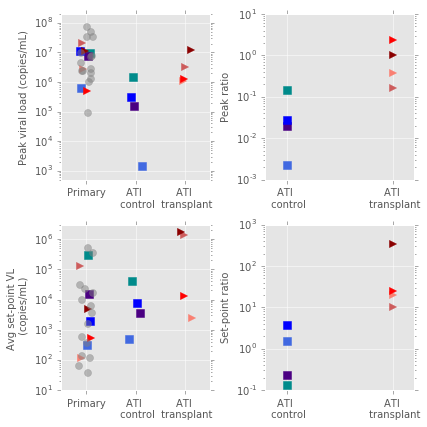

In [19]:
#compare peak viral loads
noise=0.15
plt.figure(figsize=(6,6),dpi=600)

plt.subplot(221)
cind=0; tind=0
for j in range(len(prim_df.keys())):        
    if prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Contr:
        mflag='Control'
        markz='s'
        alz=1
        col=cz[cind]
        cind+=1
    elif prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Trans:
        mflag='Transplant'
        markz='>'
        alz=1
        col=cz[tind+4]
        tind+=1 
    else:
        markz='o'
        col='gray'
        alz=0.5
    
    plt.scatter(1+np.random.uniform(low=-noise, high=noise, size=1),descripts[list_names[j]][2],
           color=col,marker=markz,alpha=alz,s=50)

for i in range(4):
    plt.scatter(2+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[7,ATI_list[i]],
                color=cz[i],s=50,marker='s')

    plt.scatter(3+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[7,ATI_list[i+4]],
                color=cz[i+4],s=50,marker='>')

plt.xticks([1,2,3],['Primary','ATI \n control','ATI \n transplant'])
plt.ylabel('Peak viral load (copies/mL)',fontsize=10)
plt.yscale('log')
plt.ylim([500,2e8])

plt.subplot(222)
for i in range(4):
    plt.scatter(1,descripts.loc[7,ATI_list[i]]/descripts.loc[2,ATI_list[i]],color=cz[i],s=50,marker='s')
    plt.scatter(2,descripts.loc[7,ATI_list[i+4]]/descripts.loc[2,ATI_list[i+4]],color=cz[i+4],s=50,marker='>')
plt.xticks([1,2],['ATI \n control','ATI \n transplant'])
plt.ylabel('Peak ratio',fontsize=10)
plt.yscale('log')
#plt.ylim([100,3e6])
#plt.xlim([100,3e6])

#compare avg viral loads
#plt.figure(figsize=(10,3),dpi=600)

plt.subplot(223)
cind=0; tind=0
for j in range(len(prim_df.keys())):        
    markz=0
    if prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Contr:
        mflag='Control'
        markz='s'
        alz=1
        col=cz[cind]
        cind+=1
    elif prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Trans:
        mflag='Transplant'
        markz='>'
        col=cz[tind+4]
        alz=1
        tind+=1 
    else:
        markz='o'
        col='gray'
        alz=0.5
    
    plt.scatter(1+np.random.uniform(low=-noise, high=noise, size=1),descripts[list_names[j]][3],
           color=col,alpha=alz,s=50,marker=markz)

for i in range(4):
    plt.scatter(2+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[8,ATI_list[i]],
                color=cz[i],s=50,marker='s')

    plt.scatter(3+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[8,ATI_list[i+4]],
                color=cz[i+4],s=50,marker='>')

plt.xticks([1,2,3],['Primary','ATI \n control','ATI \n transplant'])
plt.ylabel('Avg set-point VL \n (copies/mL)',fontsize=10)
plt.yscale('log')
plt.ylim([10,3e6])

plt.subplot(224)
for i in range(4):
    plt.scatter(1,descripts.loc[8,ATI_list[i]]/descripts.loc[3,ATI_list[i]],color=cz[i],s=50,marker='s')
    plt.scatter(2,descripts.loc[8,ATI_list[i+4]]/descripts.loc[3,ATI_list[i+4]],color=cz[i+4],s=50,marker='>')
plt.xticks([1,2],['ATI \n control','ATI \n transplant'])
plt.ylabel('Set-point ratio',fontsize=10)
plt.yscale('log')
#plt.ylim([100,3e6])
#plt.xlim([100,3e6])

plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gcf().savefig('fig3_lessdescriptivestats.pdf')  # No warning now

Maybe control group has better immune control, and transplant group just has fewer target cells! or this is an artifact of not measuring enough?, could interpolate and fit? Or maybe just takes awhile for ART to wear off?


In [ ]:
#compare the first positive time
plt.figure(figsize=(10,3),dpi=600)
plt.subplot(131)
#compare viral loads at first positive
cind=0; tind=0
for j in range(len(prim_df.keys())):        
    if prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Contr:
        mflag='Control'
        markz='s'
        col=cz[cind]
        cind+=1
    elif prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Trans:
        mflag='Transplant'
        markz='>'
        col=cz[tind]
        tind+=1 
    else:
        markz='o'
        col='gray'
    
    plt.scatter(1+np.random.uniform(low=-noise, high=noise, size=1),descripts[list_names[j]][0],
           color=col,marker=markz,alpha=0.5,s=50)

for i in range(4):
    plt.scatter(2+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[5,ATI_list[i]]-ATI_weeks[ATI_list[i]],
                color=cz[i],marker='s',s=50)

    plt.scatter(3+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[5,ATI_list[i+4]]-ATI_weeks[ATI_list[i+4]],
                color=cz[i+4],marker='>',s=50)

plt.xticks([1,2,3],['Primary','ATI \n control','ATI \n transplant'])
plt.ylabel('First pos time (weeks)',fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)

#compare viral loads at first positive
plt.subplot(132)
cind=0; tind=0
for j in range(len(prim_df.keys())):        
    if prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Contr:
        mflag='Control'
        markz='s'
        col=cz[cind]
        cind+=1
    elif prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Trans:
        mflag='Transplant'
        markz='>'
        col=cz[tind]
        tind+=1 
    else:
        markz='o'
        col='gray'
    
    plt.scatter(1+np.random.uniform(low=-noise, high=noise, size=1),descripts[list_names[j]][1],
           color=col,marker=markz,alpha=0.5,s=50)

for i in range(4):
    plt.scatter(2+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[6,ATI_list[i]],
                color=cz[i],marker='s',s=50)

    plt.scatter(3+np.random.uniform(low=-noise, high=noise, size=1),
                descripts.loc[6,ATI_list[i+4]],
                color=cz[i+4],marker='>',s=50)

plt.xticks([1,2,3],['Primary','ATI \n control','ATI \n transplant'])
plt.ylabel('First pos VL (copies/mL)',fontsize=10)
plt.yscale('log')
plt.ylim([10,2e8])

#compare log(FP)/timeFP gives surrogate for dA(R0-1)?
#velocity??
dI=0.8
plt.subplot(133)
cind=0; tind=0
for j in range(len(prim_df.keys())):        
    if prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Contr:
        mflag='Control'
        markz='s'
        col=cz[cind]
        cind+=1
    elif prim_df.keys()[j] in ATI_list and prim_df.keys()[j] in Trans:
        mflag='Transplant'
        markz='>'
        col=cz[tind+4]
        tind+=1 
    else:
        markz='o'
        col='gray'
    
    plt.scatter(1+np.random.uniform(low=-noise, high=noise, size=1),
                np.log10(descripts[list_names[j]][1])/descripts[list_names[j]][0]/dI,
           color=col,marker=markz,alpha=0.5,s=50)

for i in range(4):
    plt.scatter(2+np.random.uniform(low=-noise, high=noise, size=1),
                1+np.log(descripts.loc[6,ATI_list[i]])/
                ((descripts.loc[5,ATI_list[i]]-ATI_weeks[ATI_list[i]])*7)/dI,
                color=cz[i],s=50,marker='s')

    plt.scatter(3+np.random.uniform(low=-noise, high=noise, size=1),
                1+np.log(descripts.loc[6,ATI_list[i+4]])
                /((descripts.loc[5,ATI_list[i+4]]-ATI_weeks[ATI_list[i+4]])*7)/dI,
                color=cz[i+4],s=50,marker='>')

plt.xticks([1,2,3],['Primary','ATI \n control','ATI \n transplant'])
plt.ylabel(r'$\mathcal{R}_0$ surrogate',fontsize=10)
#plt.yscale('log')
#plt.ylim([.1,60])
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gcf().savefig('firstpos.pdf')  # No warning now

In [ ]:
#compare peak and setpoint
#plt.subplot(121)

plt.figure(figsize=(4,3),dpi=600)

for i in range(len(list_names)):
    plt.scatter(descripts.loc[2,list_names[i]],descripts.loc[3,list_names[i]],
           color='gray',alpha=0.5,s=50)

for i in range(4):
    plt.scatter(descripts.loc[7,ATI_list[i]],descripts.loc[8,ATI_list[i]],color=cz[i],s=50,marker='s')
    plt.scatter(descripts.loc[7,ATI_list[i+4]],descripts.loc[8,ATI_list[i+4]],color=cz[i+4],s=50,marker='>')
    
plt.xlabel('Peak VL (copies/mL)',fontsize=10)
plt.ylabel('Avg set-point VL (copies/mL)',fontsize=10)

plt.xscale('log'); plt.yscale('log'); 
#plt.xlim([10,2e8]); plt.ylim([10,2e8]) #square axes
plt.xlim([1e3,2e8]); plt.ylim([10,1e7]) #not square axes
#plt.semilogy(np.linspace(10,2e8,100),0.01*np.linspace(10,2e8,100),'k')

print('Spearman rho')
print(spearmanr(descripts.loc[2,list_names[:]],descripts.loc[3,list_names[:]]))
print(spearmanr(descripts.loc[7,ATI_list[0:3]],descripts.loc[8,ATI_list[0:3]]))
print(spearmanr(descripts.loc[7,ATI_list[4:7]],descripts.loc[8,ATI_list[4:7]]))

print('Pearson r')
print(pearsonr(descripts.loc[2,list_names[:]],descripts.loc[3,list_names[:]]))
print(pearsonr(descripts.loc[7,ATI_list[0:3]],descripts.loc[8,ATI_list[0:3]]))
print(pearsonr(descripts.loc[7,ATI_list[4:7]],descripts.loc[8,ATI_list[4:7]]))

plt.gcf().savefig('peak_vs_setpoint.pdf')  # No warning now